/home/diandian/.local/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/diandian/.local/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


  0%|          | 0.00/4.47G [00:00<?, ?B/s]

Generating embeddings: 100%|██████████| 1721/1721 [41:34<00:00,  1.45s/it]


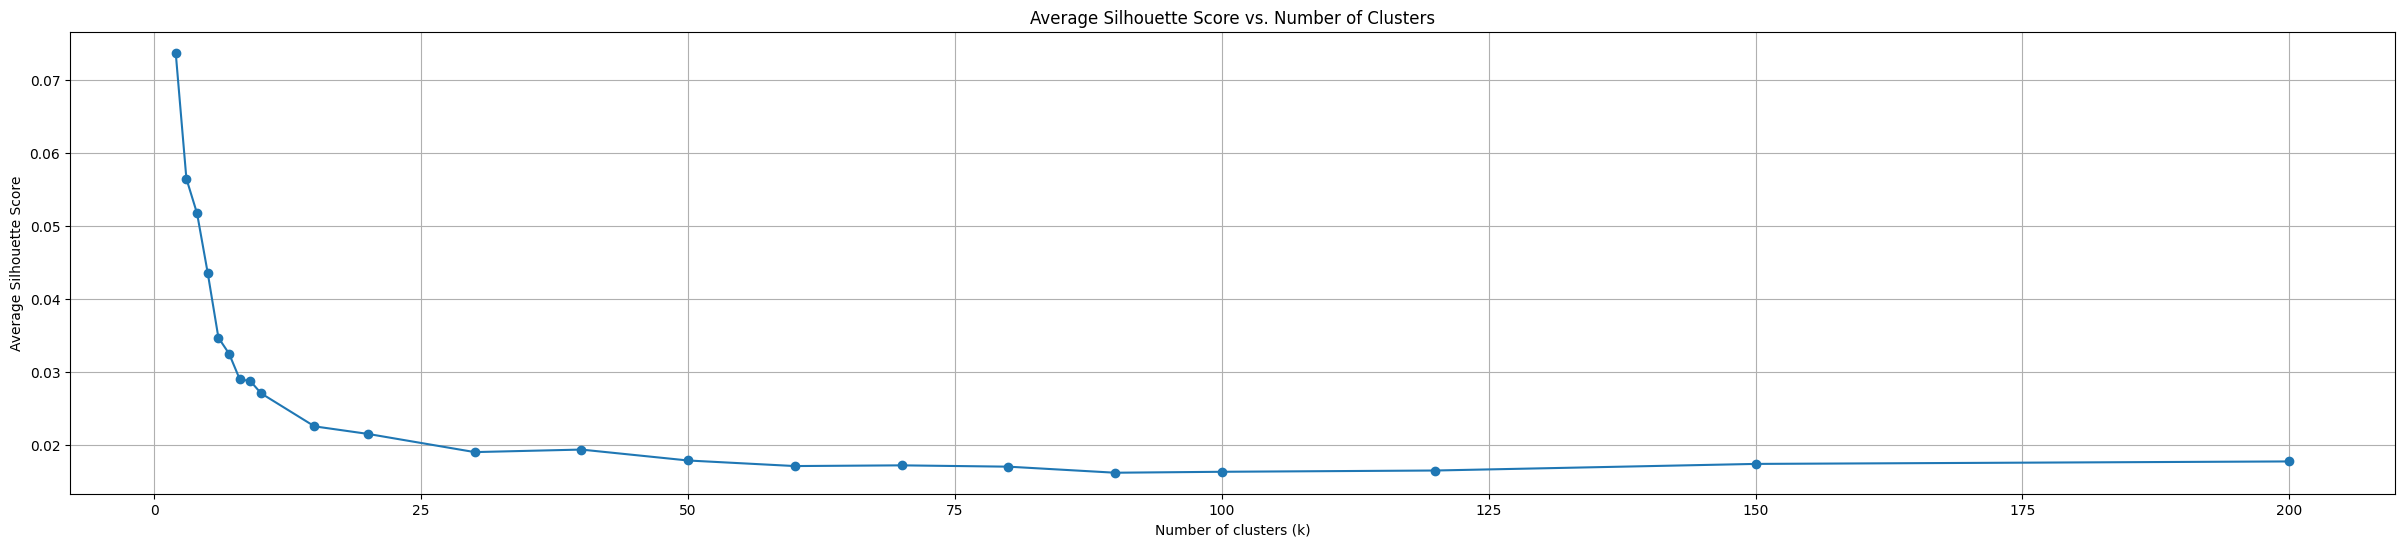

Saving clustered images: 100%|██████████| 55052/55052 [00:10<00:00, 5258.25it/s]


Clustering complete. Output saved to /home/disk1/red_disk1/test/combined_seg_img_cluster_imagebind3


In [1]:
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
from imagebind import data
from PIL import Image
from torchvision import transforms
import shutil
from tqdm import tqdm

# Paths
input_folder = '/home/disk1/red_disk1/test/combined_seg_img_pure_094'
output_folder = '/home/disk1/red_disk1/test/combined_seg_img_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Device setup
device = "cuda:1" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load image paths
image_paths = [os.path.join(input_folder, fname) for fname in os.listdir(input_folder) if fname.endswith('.png')]

# Function to load and transform a batch of images
def load_images_batch(image_paths_batch):
    images = [transform(Image.open(path).convert('RGB')) for path in image_paths_batch]
    return torch.stack(images).to(device)

# Batch size
batch_size = 32  # Adjust based on your GPU memory

# Generate embeddings in batches
all_embeddings = []
for i in tqdm(range(0, len(image_paths), batch_size), desc="Generating embeddings"):
    batch_paths = image_paths[i:i + batch_size]
    images_tensor = load_images_batch(batch_paths)
    with torch.no_grad():
        embeddings = model({ModalityType.VISION: images_tensor})
    all_embeddings.append(embeddings[ModalityType.VISION].cpu())
    torch.cuda.empty_cache()  # Clear cache to free memory

# Concatenate all embeddings
all_embeddings = torch.cat(all_embeddings, dim=0)

# Determine optimal number of clusters using Average Silhouette Method
silhouette_scores = []
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120,150,200]  # Discrete values for k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(all_embeddings.numpy())
    score = silhouette_score(all_embeddings.numpy(), labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(30, 6))  # Increased width to three times the original
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Perform clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(all_embeddings.numpy())

# Save clustered images to output folders
for idx, label in tqdm(enumerate(labels), desc="Saving clustered images", total=len(labels)):
    label_folder = os.path.join(output_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    shutil.copy(image_paths[idx], os.path.join(label_folder, os.path.basename(image_paths[idx])))

# Save labels to JSON
labels_json = {os.path.basename(image_paths[idx]): int(label) for idx, label in enumerate(labels)}
with open(os.path.join(output_folder, 'labels.json'), 'w') as f:
    json.dump(labels_json, f)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                
print(f'Clustering complete. Output saved to {output_folder}')


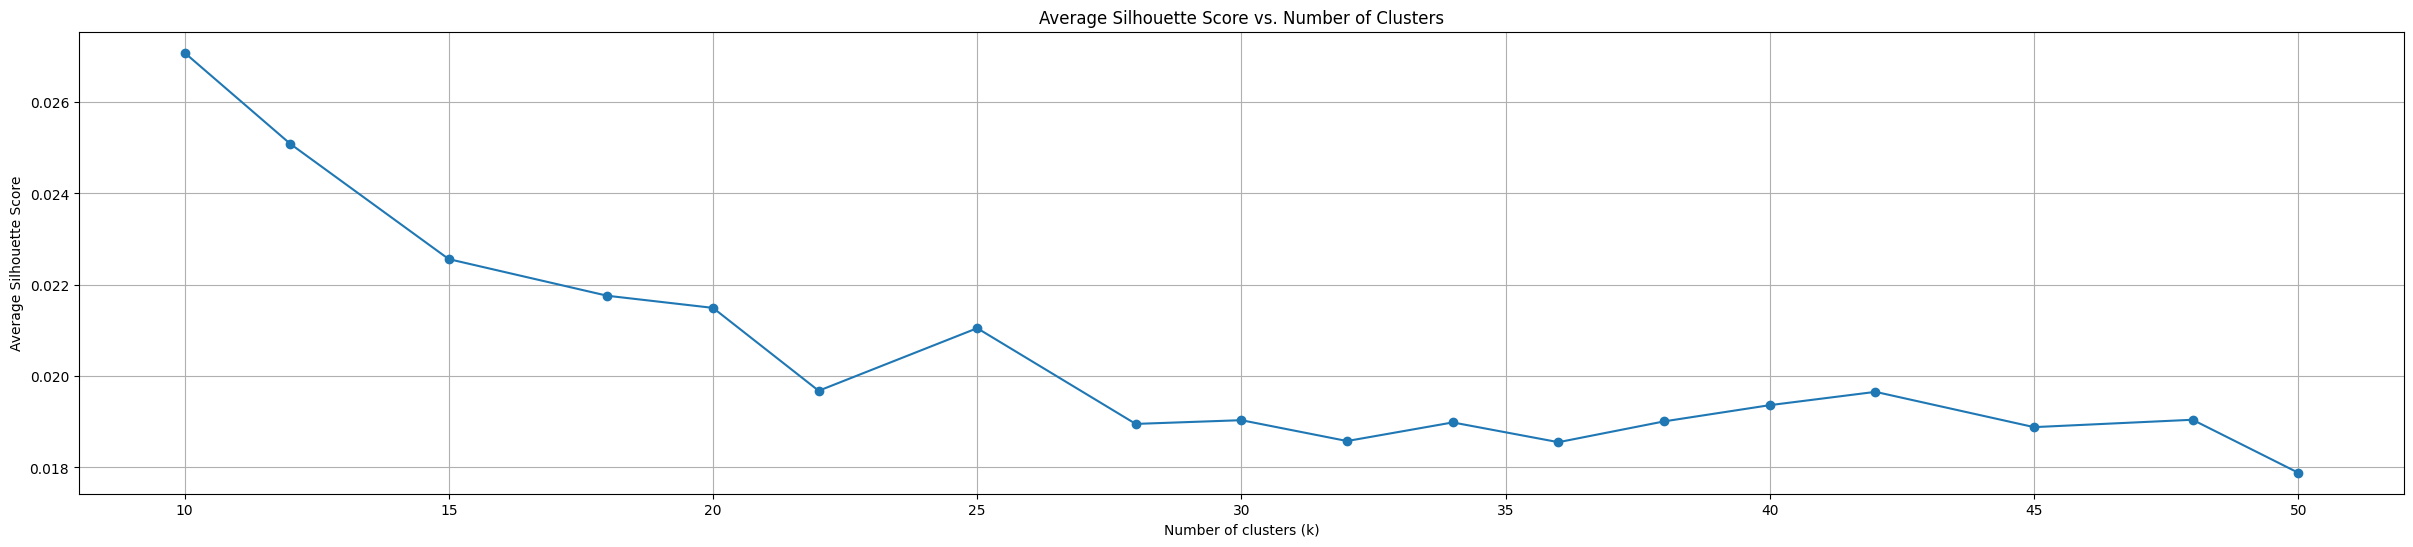

Saving clustered images: 100%|██████████| 55052/55052 [00:29<00:00, 1896.57it/s]


Clustering complete. Output saved to /home/disk1/red_disk1/test/combined_seg_img_cluster_imagebind3


In [2]:


# Determine optimal number of clusters using Average Silhouette Method
silhouette_scores = []
k_values = [10,12,15,18,20,22,25,28,30,32,34,36,38,40,42,45,48,50]  # Discrete values for k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(all_embeddings.numpy())
    score = silhouette_score(all_embeddings.numpy(), labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(30, 6))  # Increased width to three times the original
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Perform clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(all_embeddings.numpy())

# Save clustered images to output folders
for idx, label in tqdm(enumerate(labels), desc="Saving clustered images", total=len(labels)):
    label_folder = os.path.join(output_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    shutil.copy(image_paths[idx], os.path.join(label_folder, os.path.basename(image_paths[idx])))

# Save labels to JSON
labels_json = {os.path.basename(image_paths[idx]): int(label) for idx, label in enumerate(labels)}
with open(os.path.join(output_folder, 'labels.json'), 'w') as f:
    json.dump(labels_json, f)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                
print(f'Clustering complete. Output saved to {output_folder}')
